In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import time
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats

from sklearn.metrics import roc_curve, auc

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.models import load_model

path_main_folder = '/home/antorosi/Documents/Prediction'
sys.path.append(path_main_folder)

from conso.load_shape_data import load_data_conso, get_uniformed_data_conso, change_granularity, get_x_y_prediction_conso, get_train_test_sets, normalized_dataset, select_variables, add_atypical_events_to_dict_data_conso
from models.feedforward_NN import FeedForward
from aed.detection import get_next_hd_events, sort_atypical_events, get_residuals, get_atypical_score, get_atypical_ds, prediction_conso_plot, aed_conso_plot
from aed.atypical_event import AtypicalEvent, AtypicalEventsList, get_atypical_events_list, apply_ael_to_df, get_confusion_matrix
from aed.verification import *
from aed.multi_period import get_prediction_results, get_aed_results, get_complete_df

In [3]:
path_figure = os.path.join(path_main_folder, 'out', 'figures')

### Get original data 

In [4]:
# Load
path_data = os.path.join(path_main_folder, 'data')
dict_data_conso = load_data_conso(path_data)

# Uniformization
data_conso_df, dict_colnames_conso = get_uniformed_data_conso(dict_data_conso)

# Granularity from 15 min to 1H
data_conso_df = change_granularity(data_conso_df, granularity="1H")

### Multi period prediction and aed results

In [5]:
# model paths
path_models_folder = os.path.join(path_main_folder, 'out', 'cv_model_1.2')
name_dict_dataset = 'dict_datasets.pickle'
name_model = 'FFNN'
type_model = 'keras'

In [6]:
prediction_results = get_prediction_results(path_models_folder, name_dict_dataset, mode=1, type_model=type_model)

In [7]:
threshold = 0.98
aed_results, ael_full_model = get_aed_results(prediction_results, threshold)
atypical_full_df, prediction_full_df = get_complete_df(prediction_results, aed_results)

In [8]:
x = prediction_results['period_5']['detector_df']['residuals']

In [10]:
stats.kstest(x,'norm')

KstestResult(statistic=0.5043366132475542, pvalue=0.0)

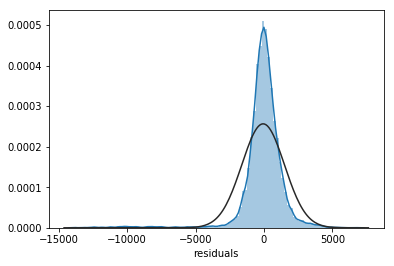

In [25]:
sn.distplot(x, bins=100, fit=stats.norm)

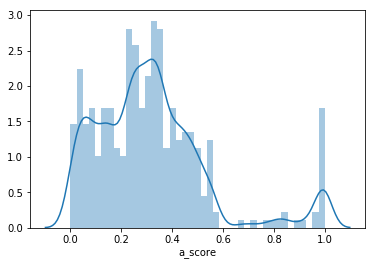

In [12]:
sn.distplot(prediction_results['period_1']['detector_df']['a_score'])

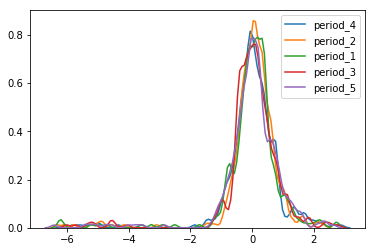

In [8]:
for period_name, period_dict in prediction_results.items():
    x = period_dict['detector_df']['z_score']
    
    x = (x - np.mean(x))/np.std(x)
    
    sn.kdeplot(x, shade=False, label=period_name)
    
plt.legend()

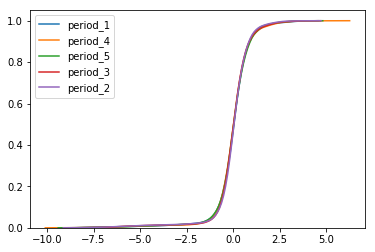

In [93]:
for period_name, period_dict in prediction_results.items():
    x = period_dict['detector_df']['residuals']
    
    x = (x - np.mean(x))/np.std(x)
    
    sn.kdeplot(x,  cumulative=True, label=period_name)
    
plt.legend()


In [81]:
x = prediction_results['period_1']['detector_df']['residuals']
y = prediction_results['period_2']['detector_df']['residuals']


In [82]:
x = (x-np.mean(x))/np.std(x)
y = (y-np.mean(y))/np.std(y)

In [80]:
x= np.random.randn(8000)
y= np.random.randn(8000)


In [83]:
stats.ks_2samp(np.array(x), np.array(y))

Ks_2sampResult(statistic=0.0318529512501427, pvalue=0.00026746224816244567)

### Fitting multivariate normal distribution to residuals 

In [9]:
residuals_df = prediction_results['period_3']['detector_df'][['ds', 'residuals']].copy()

In [10]:
diff_days = (residuals_df.ds - residuals_df.ds[0]).apply(lambda td: td.days)
residuals_df['days'] = np.array(diff_days)
residuals_df['minutes'] = residuals_df['ds'].dt.hour * 100 + residuals_df['ds'].dt.minute

In [11]:
residuals_array = residuals_df[['days', 'minutes','residuals']].pivot('days', 'minutes')

In [12]:
residuals_array[residuals_array.isna()] = residuals_array.as_matrix().mean(axis=0)[7]
residuals_array = residuals_array.as_matrix()

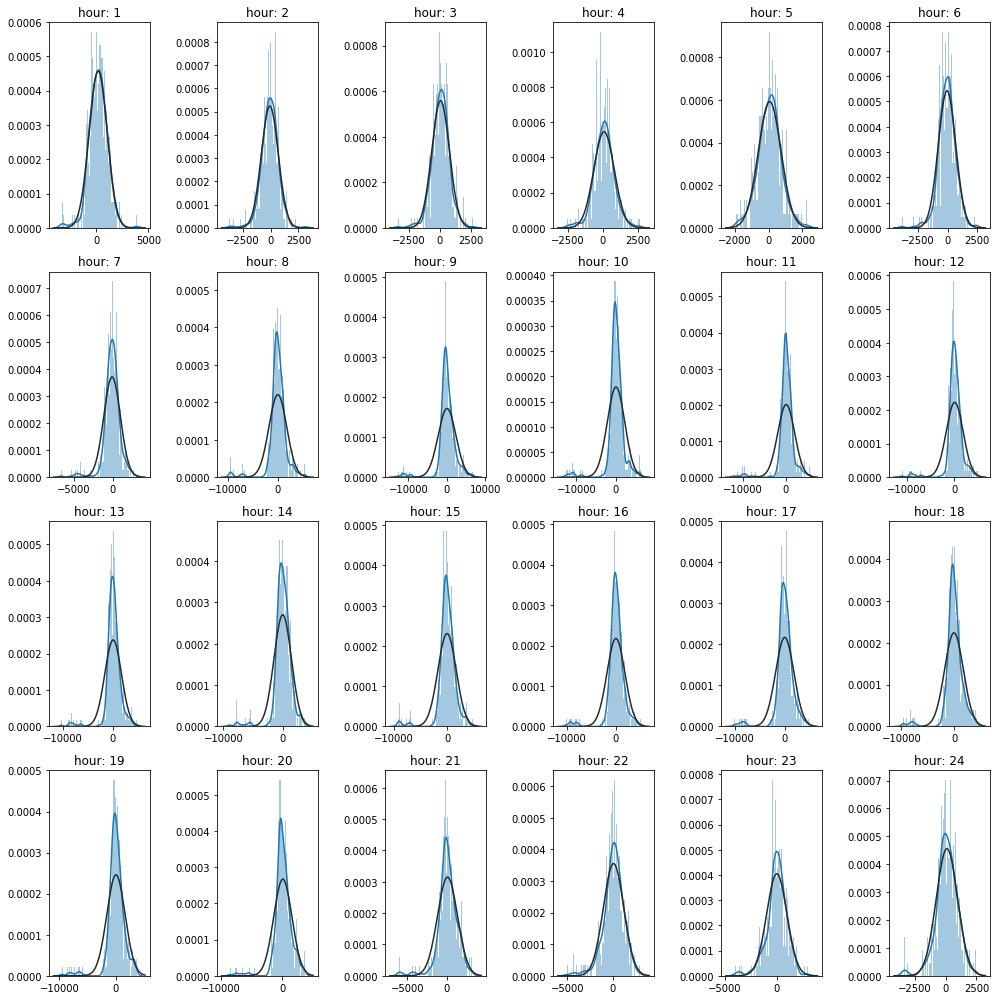

In [16]:
# Plot dist for each hours
fig, axes = plt.subplots(4,6, figsize=(14,14))

ind = 0

for ax_row in axes:
    for ax in ax_row:
        
        hour_residuals = residuals_array[:,ind]
        
        sn.distplot(hour_residuals, bins=100, fit=stats.norm, ax = ax)
        ax.set_title('hour: ' + str(ind+1))
        
        ind+=1

plt.tight_layout()

#name_plot = '{}_period1_residuals_by_hour'.format(name_model)
#plt.savefig(os.path.join(path_figure,name_plot + '.png'))
#plt.savefig(os.path.join(path_figure,name_plot + '.eps'))
#plt.show()

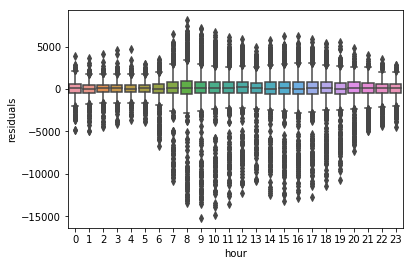

In [57]:
residuals_df['hour'] = residuals_df['ds'].dt.hour
sn.boxplot(x="hour", y="residuals", data=residuals_df)

In [13]:
residuals_norm_array = (residuals_array - residuals_array.mean(axis=0))/residuals_array.std(axis=0)

In [14]:
# Fit multivariate gaussian
mean = residuals_array.mean(axis=0)
cov = np.cov(residuals_array, rowvar=False)

#mean = residuals_norm_array.mean(axis=0)
#cov = np.cov(residuals_norm_array, rowvar=False)

In [15]:
test = stats.multivariate_normal(mean=mean, cov=cov)

In [16]:
pvalue = test.pdf(residuals_array)

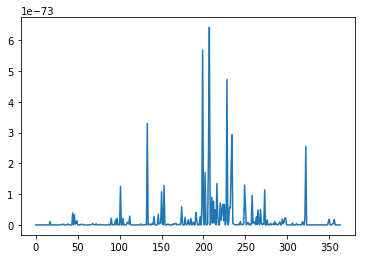

In [20]:
plt.plot(pvalue)

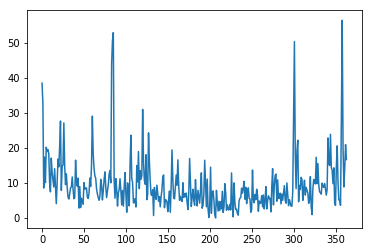

In [22]:
plt.plot(-np.log(pvalue/pvalue.max()))

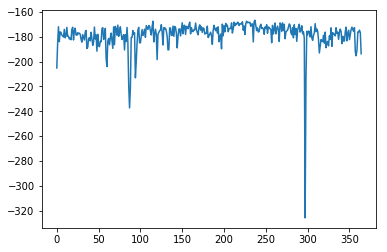

In [214]:
plt.plot(np.log(pvalue))

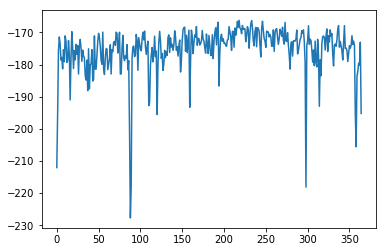

In [206]:
plt.plot(np.log(pvalue))

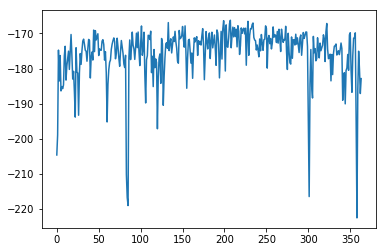

In [197]:
plt.plot(np.log(pvalue))

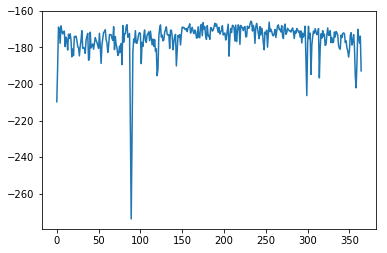

In [183]:
plt.plot(np.log(pvalue))

In [17]:
score = -np.log(pvalue/pvalue.max())

In [18]:
min_p = score.min()
max_p = score.max()

norm_score = (score - min_p)/(max_p - min_p)

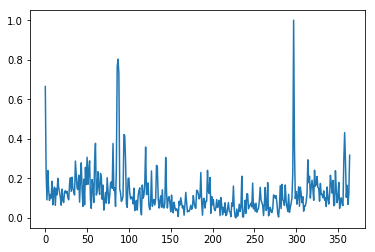

In [49]:
plt.plot(norm_score)

In [50]:
200/30

6.666666666666667

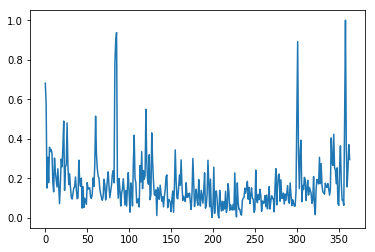

In [26]:
plt.plot(norm_score)

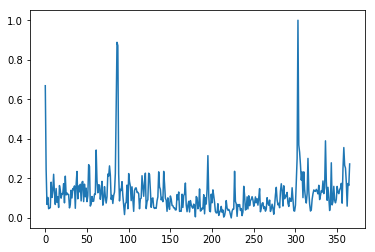

In [242]:
plt.plot(1-(norm_pvalue))

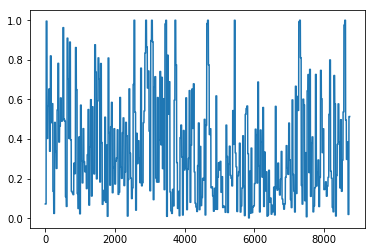

In [27]:
plt.plot(prediction_results['period_5']['detector_df']['a_score'])

In [172]:
np.log(8.62281751e-092,)

-209.68341666687422

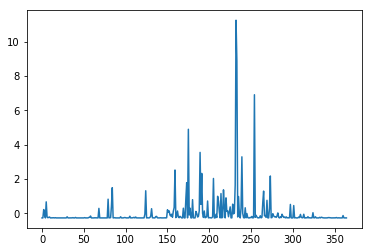

In [177]:
plt.plot((pvalue - pvalue.mean())/pvalue.std())

In [178]:
pvalue.std()

9.939712453995386e-74

In [ ]:
residuals_full_df = pd.DataFrame(columns=['residuals', 'ds'])

for dict_prediction in prediction_results.values():
        residuals_df = dict_prediction['detector_df'][['residuals', 'ds']]
        residuals_full_df = residuals_full_df.append(residuals_df)

residuals_full_df = residuals_full_df.sort_values(by='ds')
residuals_full_df = residuals_full_df.reset_index(drop=True)

In [47]:
residuals_df = prediction_results['period_4']['detector_df'][['residuals', 'ds']]

In [48]:
residuals_df = residuals_full_df.copy()

In [49]:
residuals_df_detector = residuals_df.copy()
diff_days = (residuals_df_detector.ds - residuals_df_detector.ds[0]).apply(lambda td: td.days)
residuals_df_detector['diff_days'] = diff_days

In [50]:
residuals_dist_df = residuals_df_detector.copy()
residuals_dist_df['minutes'] = residuals_dist_df['ds'].dt.hour * 100 + residuals_dist_df['ds'].dt.minute

residuals_array = residuals_dist_df[['diff_days', 'minutes','residuals']].pivot('diff_days', 'minutes')
residuals_array[residuals_array.isna()] = residuals_array.as_matrix().mean(axis=0)[7]
residuals_array = residuals_array.as_matrix()

In [51]:
mean = residuals_array.mean(axis=0)
cov = np.cov(residuals_array, rowvar=False)

dist = stats.multivariate_normal(mean=mean, cov=cov)

pvalue = dist.pdf(residuals_array)

In [52]:
score = -np.log(pvalue/pvalue.max())

min_p = score.min()
max_p = score.max()

score = (score - min_p)/(max_p - min_p)

In [53]:
score_df = pd.DataFrame({'a_score': score, 'z_score': pvalue,'diff_days': diff_days.unique()})

In [54]:
detector_ds = pd.merge(residuals_df_detector, score_df, how='left', on='diff_days')
detector_ds = detector_ds.drop(['diff_days'], axis=1)

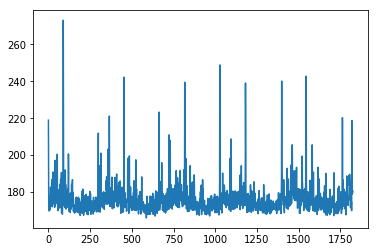

In [55]:
plt.plot(-np.log(pvalue))

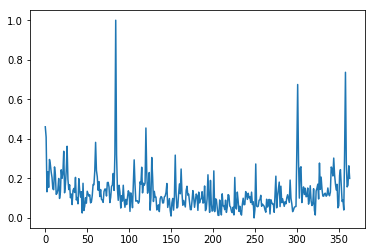

In [46]:
plt.plot(score)

In [73]:
residuals_df.shape

(8735, 2)

In [75]:
7*30

210

In [106]:
date_start = datetime.date(2017, 3,26)
date_end = datetime.date(2017, 3,27)

In [107]:
mask = (residuals_df.ds > date_start) & (residuals_df.ds < date_end)

In [108]:
residuals_df[mask]

,residuals,ds
2017,-454.101562,2017-03-26 01:00:00
2018,114.300781,2017-03-26 03:00:00
2019,774.390625,2017-03-26 04:00:00
2020,-168.578125,2017-03-26 05:00:00
2021,-142.617188,2017-03-26 06:00:00
2022,-478.812500,2017-03-26 07:00:00
2023,-945.707031,2017-03-26 08:00:00
2024,-805.164062,2017-03-26 09:00:00
2025,-1666.125000,2017-03-26 10:00:00
2026,-1438.921875,2017-03-26 11:00:00


In [109]:
mask = (data_conso_df.ds > date_start) & (data_conso_df.ds < date_end)
data_conso_df[mask]

,ds,conso_nat_t0,002Th+0,005Th+0,015Th+0,027Th+0,070Th+0,110Th+0,120Th+0,130Th+0,...,630Th+0,643Th+0,645Th+0,650Th+0,675Th+0,690Th+0,747Th+0,meteo_natTh+0,type_tempo,is_holiday_day
37173,2017-03-26 01:00:00,52240.0,8.1,8.4,8.6,7.1,2.7,7.6,7.1,8.5,...,7.8,9.0,7.2,9.1,6.0,7.7,5.6,7.494286,BLEU,0.0
37174,2017-03-26 03:00:00,50787.0,7.7,7.7,8.0,6.8,4.3,7.4,7.1,7.8,...,7.1,9.6,7.1,9.1,6.1,7.5,4.9,7.154286,BLEU,0.0
37175,2017-03-26 04:00:00,48598.0,7.1,7.5,7.2,7.0,1.8,7.4,6.9,7.5,...,6.7,10.8,8.6,8.7,5.3,7.3,5.6,6.774286,BLEU,0.0
37176,2017-03-26 05:00:00,46063.0,7.1,7.0,6.8,6.6,1.5,7.5,6.8,8.1,...,6.4,9.6,8.4,9.2,5.4,7.1,4.7,6.342857,BLEU,0.0
37177,2017-03-26 06:00:00,45855.0,6.8,6.2,6.4,6.3,1.1,7.0,6.1,7.0,...,6.1,8.5,7.6,9.0,5.3,6.5,4.1,5.840000,BLEU,0.0
37178,2017-03-26 07:00:00,46800.0,6.0,6.2,5.9,5.8,0.3,6.7,5.4,6.2,...,5.0,8.3,6.4,8.5,5.2,6.7,3.8,5.334286,BLEU,0.0
37179,2017-03-26 08:00:00,46926.0,5.7,6.0,5.6,4.0,2.4,6.1,5.8,6.3,...,6.2,8.4,7.0,8.7,4.5,6.9,4.4,5.525714,BLEU,0.0
37180,2017-03-26 09:00:00,49145.0,5.8,6.8,6.4,6.2,5.2,6.4,6.1,7.8,...,6.4,9.4,10.0,10.4,4.7,8.6,6.5,6.997143,BLEU,0.0
37181,2017-03-26 10:00:00,50635.0,8.0,8.4,9.1,8.6,9.5,8.4,6.9,9.1,...,9.0,11.4,10.3,12.6,6.3,10.9,10.7,9.002857,BLEU,0.0
37182,2017-03-26 11:00:00,51600.0,10.7,10.4,11.4,10.0,11.7,9.5,7.6,10.1,...,12.2,11.9,13.1,14.5,10.0,13.5,13.2,10.934286,BLEU,0.0


In [130]:
ds = data_conso_df.ds

In [131]:
ds_shifted = ds.shift(1)
ds_shifted[0] = ds[0] - datetime.timedelta(hours=1)

In [132]:
set(ds-ds_shifted)

{Timedelta('0 days 01:00:00'), Timedelta('0 days 02:00:00')}

In [134]:
mask = ds-ds_shifted == datetime.timedelta(hours=2)

In [135]:
ds[mask]

2234    2013-03-31 03:00:00
10969   2014-03-30 03:00:00
19704   2015-03-29 03:00:00
28439   2016-03-27 03:00:00
37174   2017-03-26 03:00:00
Name: ds, dtype: datetime64[ns]